# Writer Identification

This notebook is a part of my thesis which theme is offline writer identification. I've researched multiple papers concerning different models and techniques for identifying a writer of a text based on their writing style. We'll be using IAM database which has aproximately 650 unique writers. [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database/download-the-iam-handwriting-database).

# Manipulating the dataset

First step is to pair each sentence with its respective writer. Crosschecking with ``forms.txt`` file.

In [2]:
# This part creates a dictionary 
# and stores pairs of form ID and writer ID 

import os
from itertools import islice

formWriter = {}
formsFilePath = "../data/forms.txt"
with open(formsFile_Path) as f:
    for line in islice(f, 16, None):
        lineList = line.split(' ')
        formId = lineList[0]
        writer = lineList[1]
        formWriter[formId] = writer

As jupyter notebooks are a visual medium, here's some content of the dictionary "formWriter" displayed. The dictionary contains pairs of form ID and writer ID.

In [3]:
list(formWriter.items())[0:5]

[('a01-000u', '000'),
 ('a01-000x', '001'),
 ('a01-003', '002'),
 ('a01-003u', '000'),
 ('a01-003x', '003')]

As computing power is limited even with 16gb ram and 4 core virtual machine, I will filter from the whole dataset the 50 most active writers out of 221 in this dataset.

In [4]:
# Selection of writers with most content. In this case top 50 writers.

from collections import Counter

topWriters = []
numWriters = 50
writersCounter = Counter(formWriter.values())
for writerId,_ in writersCounter.most_common(numWriters):
    topWriters.append(writerId)

Check if the topWriters array got filled with correct writer IDs

In [5]:
print(topWriters[0:5])

['000', '150', '151', '152', '153']


Filter the dataset so that only the sentence IDs that correspond to the "topWriters" array writer IDs are left.

In [6]:
topForms = []
for formId, authorId in formWriter.items():
    if authorId in topWriters:
        topForms.append(formId)

Here are couple of the sentence IDs after filtering:

In [7]:
print(topForms[0:5])

['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']


Now we have a "topForms" array that has listed every sentence ID we need for this project. We need a new container for the new list of sentences for easier handling later on. Let's create one!

In [8]:
import os
import glob
import shutil

# Temporal directory for top sentences
# NOTE: This snippet assumes it's been executed already if the "temp_sentences" folder exists
# If for some reason you want to run the "copyfile" half of this snippet, remove that folder.
tempSentencesPath = "../data/temp_sentences"
if not os.path.exists(tempSentencesPath):
    os.makedirs(tempSentencesPath)
    
    # NOTE: Place the original sentences folder according to the path here
    # Copies files according to "topForms" array
    originalSentencesPath = "../data/sentences/**/**/*.png"
    for filePath in glob.glob(originalSentencesPath):
        imageName = filePath.split('/')[-1]  
        fileName, _ = os.path.splitext(imageName)
        formId = '-'.join(fileName.split('-')[0:2])
        if formId in topForms:
            shutil.copy2(filePath, tempSentencesPath + "/" + imageName)

Create "imgFiles" array of the temp folder sentence files and another "imgLabels" array for holding the top 50 writer IDs.

In [9]:
import numpy as np

imgFiles = np.zeros((0), dtype=np.str)
imgLabels = np.zeros((0), dtype=np.str)
pathToFiles = os.path.join(tempSentencesPath, '*')
for filePath in glob.glob(pathToFiles):
    imgFiles = np.append(imgFiles, filePath)
    fileName, _ = os.path.splitext(filePath.split('/')[-1]  )
    formId = '-'.join(fileName.split('-')[0:2])
    for key in formWriter:
        if key == formId:
            imgLabels = np.append(imgLabels, formWriter[form_id])

Visualize the selected filenames.

In [10]:
print(imgFiles[0:5])

['../data/temp_sentences/g06-026e-s02-00.png'
 '../data/temp_sentences/a01-058u-s00-01.png'
 '../data/temp_sentences/n02-127-s00-01.png'
 '../data/temp_sentences/b06-000-s00-02.png'
 '../data/temp_sentences/m06-083-s03-00.png']


A good time to check how matplotlib works with the copied sentence files.

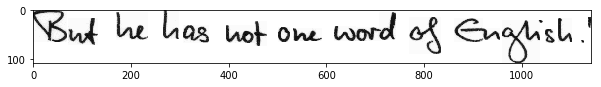

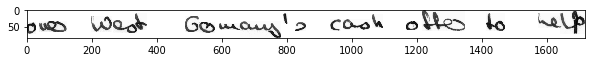

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

for fileName in imgFiles[:2]:
    img = mpimg.imread(fileName)
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap ='gray')

# Encoding writer names

As neural networks are inherently stupid they will try to figure nonexistant relations between the writer ID numbers, so the numbers need to be processed from strings into number order.

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(imgLabels)
encodedImgLabels = encoder.transform(imgLabels)

print("Writer ID        : ", imgLabels[:7])
print("Encoded writer ID: ", encodedImgLabels[:7])

Writer ID        :  ['336' '000' '315' '123' '552' '634' '347']
Encoded writer ID:  [26  0 21  6 43 46 37]


# Divide dataset

This selected dataset need to be divided into training, validation and testing sets

`Training set` is the data used to fit the model. It is the actual data set that is used to train the model. (and by training is meant figuring out the weights and biases) The model sees and learns from this data.

`Validation set` is used to have unbiased evaluation of a model while tuning the model. The model sees the data and gives accuracy of the prediction, but the model doesn't learn from it.

`Test set` is like validation set, but used only after all the training is done. Test set doesn't affect the model in any way. Test set can be used to evaluate multiple different models (in a competitive sense perhaps). Usually the test set is also curated to include all different categories of the larger data set. In our case the test set is only random sample from the data set.

There are methods of calculating most efficient ratios between the sizes of training, validation and testing sets. 

I will settle for now to approximately dividing with 4:1:1 ratio as training dataset needs to be the biggest.

In [16]:
from sklearn.model_selection import train_test_split

# Split dataset into training trainFiles & trainLabels 
# and test sets remFiles & remLabels
trainFiles, remFiles, trainLabels, remLabels = train_test_split(
    imgFiles, encodedImgLabels, test_size=0.66, shuffle = True)

# Further split training set into training and validation sets
valFiles, testFiles, valLabels, testLabels = train_test_split(
    remFiles, remLabels, test_size=0.5, shuffle = True)

# Check that ratios are correct and both files and Labels have equal amounts
print(trainFiles.shape, valFiles.shape, testFiles.shape)
print(trainLabels.shape, valLabels.shape, testLabels.shape)

(3239,) (809,) (809,)
(3239,) (809,) (809,)


# Crop sentences into patches

Couple commonly used constants defined.
The `batch size` the model uses is 16. It means that the model is trained in 16 image sample batches. Batch size is one of many `hyperparameters` and it is considered that batch size should be in range of 16-128.

Using batches makes the training faster and more accurate as weights are updated after each batch. Also batches are necessary as the whole dataset wouldn't fit in the memory.

Other hyperparameters are: 

`learning rate` Might be the most important hyperparameter. The amount the backpropagation updates the weights during training is referred as the learning rate. We are using Adam to adapt the learning rate.   Adam is in the model design part.

`number of epochs` This depends on every data set. Trial and error is the way to go. It is also possible to use high number of epochs and let `EarlyStopping()` function to monitor some percentage.

`activation function` We use ReLU to introduce nonlinearity.

`number of hidden layers`. Usually good to add layers until the test error improves. Though every layer makes the model more expensive to train.

`weight initialization`. Usually weights are initialized with random number to avoid dead nodes.

`Dropout value` Regular value is half (0.5) of the nodes. Dropout shuts off random nodes for avoiding overfitting.

In [17]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

The model is designed to take identical sized patches of images. First ``samplePreProcessor`` function takes every sentence and resizes the sentence's height to 113 pixels. 

Secondly the resized sentences are cropped vertically to create squares of 113x113 pixels. The cropping is random so inside the sample image is a random part of the sentence.

In [18]:
from sklearn.utils import shuffle
from PIL import Image
import random

def samplePreProcessor(sample, label, sampleRatio):
    # Get current image details
    img = Image.open(sample)
    imgWidth = img.size[0]
    imgHeight = img.size[1]

    # Resize and maintain the original aspect ratio.
    heightFac = CROP_SIZE / imgHeight
    size = (int(imgWidth * heightFac), CROP_SIZE)
    newImg = img.resize((size), Image.ANTIALIAS)
    newImgWidth = newImg.size[0]
    newImgHeight = newImg.size[1]

    # Calculate how many sample images are cropped from a sentence
    XCoord = list(range(0, newImgWidth - CROP_SIZE))
    numCrops = int(len(XCoord) * sampleRatio)
    randXCoord = random.sample(XCoord, numCrops)
    
    # Create 113x113 sized sample images by cropping
    # Also map sample to its writer (label in the code below)
    images = []
    labels = []
    for x in randXCoord:
        imgCrop = newImg.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(imgCrop))
        labels.append(label)

    return (images, labels)

# Example of how the cropping happens

This part uses an example to visualize step by step what ``samplePreProcessor`` function does. 

Here is an example of a single sentence which the function will operate with:

Label:  0


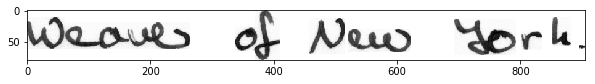

In [23]:
sample, label = trainFiles[0], trainLabels[0]
img = mpimg.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

Time to use the chosen sentence with ``samplePreProcessor`` function:

In [24]:
images, labels = samplePreProcessor(sample, label, 0.1)

``samplePreProcessor`` returns ``labels`` and ``images``. 

``label`` is the original sentence's writer id which is given to each of the random image patches. In this example the label (or writer id) is `0`.

`images` are the actual sample patches. `samplePreProcessor` created 116 patches out of that single sentence. Here is couple of them.

116


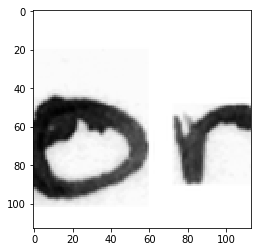

In [26]:
print(len(images))
plt.imshow(images[0], cmap ='gray')

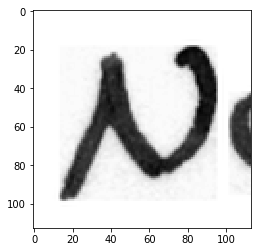

In [27]:
plt.imshow(images[1], cmap ='gray')

# Generator function

Think of the generator function as an iterator. An iterator loops through the elements of an object, like items in a list or keys in a dictionary. Generator ``yields`` batches of cropped images with each iteration.

Big benefit of using generators is saving memory. And so generators are used with applications that need a lot of memory.

In the case of this project, when the CNN is trained with the image patches the GPUs would get memory errors if all of the sample images were uploaded on the memory. 

Using a generator, you only need to keep the images for your training batch in memory as opposed to all your training images.

This article from Shervine Amidi was a great help https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

`Flattening` helps to reshape the input data to fit in the convolution layers.
`One-hot encode` is used with categorization problems. It converts the `writer ID` array into a table so neural network can't find any imaginary connections between the ID numbers.


In [28]:
import operator
from functools import reduce
from keras.utils import to_categorical

def generate(samples, labels, batchSize, sampleRatio):
    while 1: 
        for offset in range(0, len(samples), batchSize):
            batchSamples = samples[offset:(offset + batchSize)]
            batchLabels = labels[offset:(offset + batchSize)]
            
            # Create batches
            augBatchSamples = []
            augBatchLabels = []
            for i in range(len(batchSamples)):
                sample = batchSamples[i]
                label = batchLabels[i]
                augSamples, augLabels = samplePreProcessor(sample, label, sampleRatio)
                augBatchSamples.append(augSamples)
                augBatchLabels.append(augLabels)

            # Flatten out samples and labels
            augBatchSamples = reduce(operator.add, augBatchSamples)
            augBatchLabels = reduce(operator.add, augBatchLabels)
            
            # Reshape input format to fit in the model
            trainFiles = np.array(augBatchSamples)
            trainFiles = trainFiles.reshape(trainFiles.shape[0], CROP_SIZE, CROP_SIZE, 1)

            # input to float and normalize
            trainFiles = trainFiles.astype('float32')
            trainFiles = trainFiles / 255

            # One hot encode trainLabels
            # This will make a table from the array of labels.
            # It is to make sure the CNN does not try to find features from them
            trainLabels = np.array(augBatchLabels)
            trainLabels = to_categorical(trainLabels, NUM_LABELS)

            yield trainFiles, trainLabels

Using TensorFlow backend.


The generator function can be now used with all three dataset parts.

In [29]:
trainGenerator = generate(trainFiles, trainLabels, BATCH_SIZE, 0.3)
valGenerator = generate(valFiles, valLabels, BATCH_SIZE, 0.3)
testGenerator = generate(testFiles, testLabels, BATCH_SIZE, 0.1)

In [30]:
import tensorflow as tf

config = tf.ConfigProto()
tf.Session(config = config)

In [31]:
def resize_image(img):
    size = round(CROP_SIZE/2)
    return tf.image.resize_images(img, [size, size])

# CNN model

Here is the 10-layer CNN model. The code describes the shape of the model and it's components. After building the code, it outputs a table of the model below. The total amount of parameters is the sum of all weights and biases. Check it out!

I have `CNN` as the main model, `ReLu` as the activation function instead of sigmoid. As this is a categorization problem (as in calculating probability of a sentence belonging to a single writer from the pool of 50) it makes sense to use softmax activation function as the final layer.

Conventionally after every convolution layer a non-linearity is applied. For example a non-linear activation function. `ReLu activation` is usually used with `CNN` as it is computationally more efficient than sigmoid, without sacrifising much accuracy.

`Sequential model` makes a linear stack of layers. It is the simplest CNN model. The are also parallel models of CNN. 

`Convolution layer` finds features from the source image by blurring, sharpening, edge detection, noise reduction and with other operations.

`Pooling layer` reduces the image dimensionality without losing important features or patterns.

`Flattening layer` prepares the pooled feature map to be inserted in a regular neural network layer.
Visual about flattening: https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-step-3-flattening

`Dropout` prevents overfitting. A fully connected layer takes most of the parameters (if you check the table below the first dense layer consists of 590,000 of total ~872,000 parameters). During training the model's neurons develop co-dependency among each other, which leads to overfitting. 
Dropout layer shuts down randomly selected nodes, an forces the neural network to learn more robust features.  Usual practice is to have half of the nodes on one layer turned offline. Great article about overfitting and dropout: https://www.datascience.us/neural-net-dropout-dealing-overfitting/

`Accuracy` (acc) is the accuracy of a batch of training data. It tells how the model is progressing in terms of its training. `Validation accuracy` (val_acc) is the accuracy of a batch of a validation data (data that have never been 'seen' by the model). Validation accuracy can be used as an evaluation of the quality of the model. How the model is predicting the never before seen data.
`Training loss` is the average of the losses over each batch of training data. The last accuracy value is about 86%, and the validation accuracy is 90%. 90% is the probable accuracy on new data.

`categorical cross entropy` is usually used with categorization problems. It compares the predicted label and true label, calculating the loss.

`Adam` is a 

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics

model = Sequential()

# Define network input shape
model.add(ZeroPadding2D((1, 1), input_shape=(CROP_SIZE, CROP_SIZE, 1)))
# Resize images to allow for easy computation
model.add(Lambda(resize_image)) 

# CNN model
# 1. convolution layer with ReLU activation
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2, 2), padding='same', name='conv1'))
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

# 2. convolution layer
model.add(Convolution2D(filters= 64, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv2'))
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

# 3. convolution layer
model.add(Convolution2D(filters= 128, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv3'))
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))

# Flatten
model.add(Flatten())
model.add(Dropout(0.5))

# Dense aka regular layer of neural network.
model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Dense 
model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Softmax activation since the output is within 50 classes (50 different writers)
model.add(Dense(NUM_LABELS, name='output'))
model.add(Activation('softmax'))

# Using categorical crossentropy and adam.
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

The model is trained for 40 epochs. One `epoch` is one full training cycle of the whole training set. After the weights have been set, another epoch begins. 

We can't be sure how many epochs is enough for good accuracy. I've trained the same model with 20 epochs and the accuracy afterwards on testing set was ~80.34%. This time the training time is doubled to see how much it will improve. The accuracy is easier to be judged after seeing all data points. If validation and training set accuracy start to fluctuate back and forth, it is a symptom of overfitting.

The model obtained after a single epoch is saved to the `./checkpoints` folder.

Keras has fit() and fit_generator().
fit() is used with small data set as it is passed whole into the function.
fit_generator() the dataset comes from generator that was built earlier. Generator is used to avoid memory issues as it gives data set in batches.
How to use fit_generator https://keras.io/models/sequential/#fit_generator

In [22]:
from keras.callbacks import ModelCheckpoint

# Create directory to save checkpoints at
checkpointsPath = "./checkpoints"
if not os.path.exists(checkpointsPath):
    os.makedirs(checkpointsPath)
    
# Save model after every epoch using checkpoints
createCheckpoint = ModelCheckpoint(
    filepath = "./checkpoints/check_{epoch:02d}_{val_loss:.4f}.hdf5",
    verbose = 1,
    save_best_only = False
)

# Use generators 
# How to use fit_generator https://keras.io/models/sequential/#fit_generator
# Keras has fit() and fit_generator()
# We use fit_generator because to avoid memory issues
history_object = model.fit_generator(
    train_generator, 
    steps_per_epoch = round(len(trainFiles) / BATCH_SIZE),
    validation_data = valGenerator,
    validation_steps = round(len(valFiles) / BATCH_SIZE),
    epochs = 40,
    verbose = 1,
    callbacks = [create_checkpoint]
)

Epoch 1/40
196/196 [==============================] - 443s 2s/step - loss: 3.5442 - acc: 0.1665 - val_loss: 3.1511 - val_acc: 0.2480

Epoch 00001: saving model to ./checkpoints/check_01_3.1511.hdf5
Epoch 2/40
196/196 [==============================] - 146s 742ms/step - loss: 2.9741 - acc: 0.2246 - val_loss: 2.5199 - val_acc: 0.3031

Epoch 00002: saving model to ./checkpoints/check_02_2.5199.hdf5
Epoch 3/40
196/196 [==============================] - 146s 746ms/step - loss: 2.5296 - acc: 0.2957 - val_loss: 2.2370 - val_acc: 0.3558

Epoch 00003: saving model to ./checkpoints/check_03_2.2370.hdf5
Epoch 4/40
196/196 [==============================] - 144s 737ms/step - loss: 2.2046 - acc: 0.3624 - val_loss: 1.9015 - val_acc: 0.4326

Epoch 00004: saving model to ./checkpoints/check_04_1.9015.hdf5
Epoch 5/40
196/196 [==============================] - 144s 737ms/step - loss: 1.9714 - acc: 0.4149 - val_loss: 1.6770 - val_acc: 0.4984

Epoch 00005: saving model to ./checkpoints/check_05_1.6770.hdf

Inside the 40 epochs alternate training and validation accuracy. Validation accuracy seems to be always a bit higher than the training set accuracy. 

`loss` is the loss on the training set. Calculated every epoch.

`val_loss` is the loss on the validation set. Also calculated every epoch.

The values of loss and val_loss are logarithmic and solely looking at the values won't give much insight. The model gets more accurate even when the loss values are that high. It means the prediction are going great, but the model itself is not confident about the predictions.

To find out if the model is overfitting, cross-validation is used. 

# Prediction accuracy

After training the model can be found in "checkpoints" folder.
The model_weights.hdf5 file can be used to predict the remaining test set:

In [26]:
modelWeightsPath = "./checkpoints/model_weights.hdf5"
if modelWeightsPath:
    model.loadWeights(modelWeightsPath)
    scores = model.evaluate_generator(testGenerator, steps=round(len(testFiles)/BATCH_SIZE))
    print("Accuracy: ", scores[1])
else:
    print("Set model weights file to load in the 'modelWeightsPath' variable")

Accuracy:  0.9096616865456947
